## **Task**

Here we have some data about health insurance. Stakeholders provide us data with task of analysis and predictive modeling of insurance price based on provided features.

In this notebook we will try to apply clustering methods to our dataset. We will apply clustering because we saw previously that our clients are clearly divided into three categories.

This dataset was founded on Kaggle. [dataset online](https://www.kaggle.com/datasets/mirichoi0218/insurance)

In [ ]:
# some imports of packages needed
# for data exploration and visualization
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# tools we need to perform cluster analysis 
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, davies_bouldin_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# first things first: let's get our data and look and it.
data_path = "/content/drive/MyDrive/Data Analyst Pet Project/Data/insurance.csv"

df = pd.read_csv(data_path)

df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## **Data Transformation**

First of all we must encode some features in our dataset from text format to numerical.

In [ ]:
def dataset_encoding(df:pd.DataFrame, columns_to_encode:list=["sex", "smoker", "region"]):
    """
        This function transform text data to numerical,
        for example {'male': 1, 'female':0} etc
    """
    # we use this class to encode our data
    enc = OrdinalEncoder(dtype='float32', handle_unknown='use_encoded_value',
                         unknown_value=np.nan)
    # apply encoder to our data
    enc.fit(df[columns_to_encode])
    # transform data with trained encoding
    encoded_df = enc.transform(df[columns_to_encode])
    # drop textual columns
    df = df.drop(columns=columns_to_encode)
    # insert newly created into dataframe
    df[columns_to_encode] = encoded_df
    # output encoder, dataframe
    return enc, df.astype('float32')

Check the results of transformation

In [ ]:
ordinal_encoder, df = dataset_encoding(df)
df.head()

,age,bmi,children,charges,sex,smoker,region
0,19.0,27.900000,0.0,16884.923828,0.0,1.0,3.0
1,18.0,33.770000,1.0,1725.552246,1.0,0.0,2.0
2,28.0,33.000000,3.0,4449.461914,1.0,0.0,2.0
3,33.0,22.705000,0.0,21984.470703,1.0,0.0,1.0
4,32.0,28.879999,0.0,3866.855225,1.0,0.0,1.0


The next part is to scale our data to the interval from 0 to 1 for continuous variables

In [ ]:
def dataset_scaling(df:pd.DataFrame, columns_to_scale:list=["bmi", "charges"]):
    """
        This function transform continuous variables to the interval from 0 to 1
    """
    # we use this class to encode our data
    scaler = MinMaxScaler()
    # apply encoder to our data
    scaler.fit(df[columns_to_scale])
    # transform data with trained encoding
    scaled_df = scaler.transform(df[columns_to_scale])
    # drop textual columns
    df = df.drop(columns=columns_to_scale)
    # insert newly created into dataframe
    df[columns_to_scale] = scaled_df
    # output dataframe
    return scaler, df.astype('float32')

In [ ]:
scaler, df = dataset_scaling(df)
df.head()

,age,children,sex,smoker,region,bmi,charges
0,19.0,0.0,0.0,1.0,3.0,0.321227,0.251611
1,18.0,1.0,1.0,0.0,2.0,0.479150,0.009636
2,28.0,3.0,1.0,0.0,2.0,0.458434,0.053115
3,33.0,0.0,1.0,0.0,1.0,0.181464,0.333010
4,32.0,0.0,1.0,0.0,1.0,0.347592,0.043816


we done with our preprocessing steps, let's move on to clustering


---



## **Clustering**

In clustering there are no good way to evaluate results, but often scientists, if possible, just apply many clustering methods and metrics to say what is ther correct number of clusters presented.
<br>
<br>
So in this notebook, we will apply two methods: Hierarchical clustering and K-Means. And two metrics: Silhoette score and Davies-Bouldin metrics.

### Hierarchical Clustering

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
def hierarchical_clustering(df, metric):
    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(n_clusters=None, distance_threshold=2,
                                    linkage='average', affinity=metric)
    # apply clustering algorithm
    model = model.fit(df)

    # plotting results
    plt.figure(figsize=(11, 9))
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model, truncate_mode="level", p=3)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.ylabel("Maximum distance between clusters")
    plt.show()

Applying hierarchical clustering algorithm with **Euclidean distance**

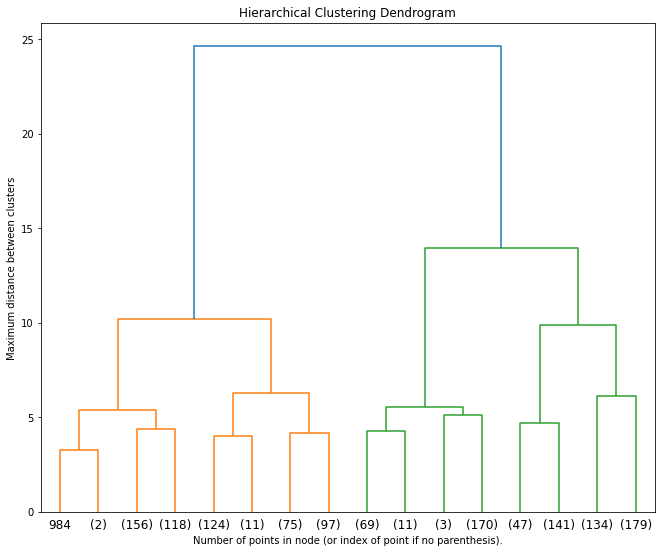

In [ ]:
hierarchical_clustering(df, metric='euclidean')

From this dendrogram we can clearly see that we have here 3 clusters, as mentioned in data exploration notebook

Let's use **cosine similarity** as a metric

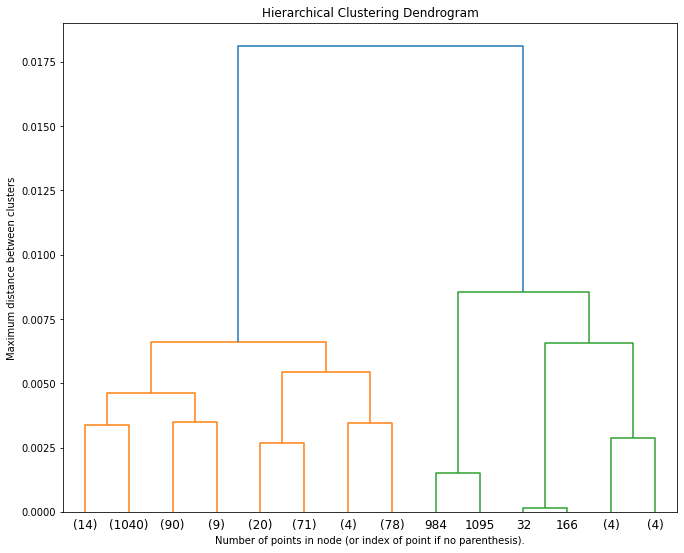

In [ ]:
hierarchical_clustering(df, metric='cosine')

And with cosine distance we have three clusters.

### K-Means Clustering

Let's build a function to visualize clustering with K-Means method

In [ ]:
def visualise_clustering(df, model, return_model=False):
    '''
    Function displays six plots
    among different features to give a representation
    of how clusters look.
    '''
    # applying model to the dataframe
    clst = model
    clst.fit(df)
    # get cluster labels
    y_clst = clst.labels_
    df_tmp = df.copy().reset_index(drop=True)
    df_tmp['clusters'] = y_clst
    # count the number of clusters
    n = len(np.unique(y_clst))

    # plotting data
    sns.pairplot(df_tmp[['age', 'bmi', 'children', 'charges', 'smoker', 'region', 'clusters']], hue="clusters", palette="Set2")
    plt.show()

    if return_model is True:
        return clst

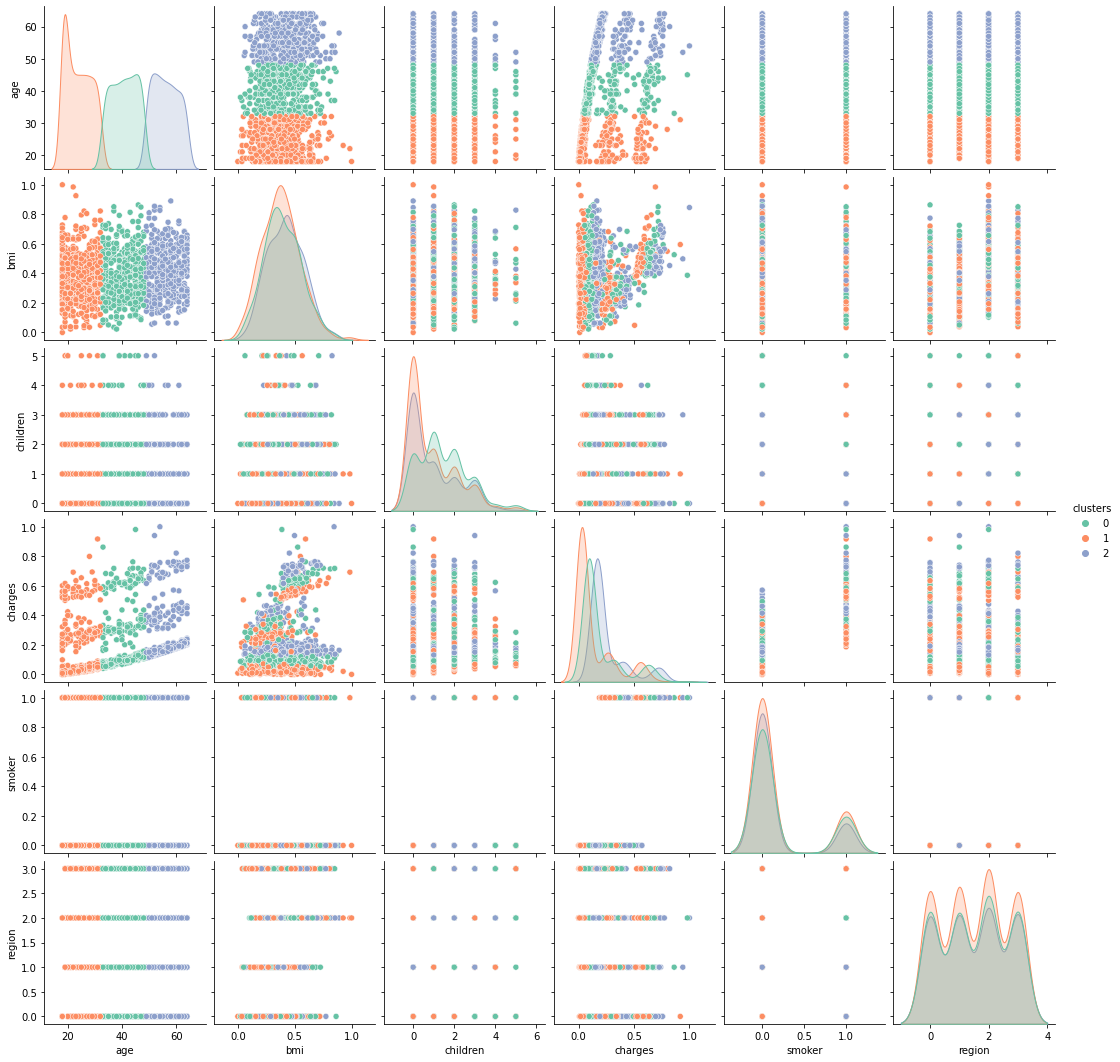

In [ ]:
visualise_clustering(df, KMeans(n_clusters=3))

Well due to the limitations of K-Means algorithm we can't capture the shape of clusters, but let's apply `elbow method` to evaluate number of clusters.

In [ ]:
def elbow_method_kmeans(df, model, clusters_range):
    """
        This function plots elbow to evaluate K-Means clustering algorithm
        by calculating Within-Cluster Sum of Square, we should seek for
        breaking point at the displayed line
    """
    # list to collect WCSS scores
    wcss = []

    # applying clustering and collecting scores
    for i in clusters_range:
        # clustering
        clst = model(n_clusters=i, random_state=42)
        clst.fit(df)
        # collecting scores
        wcss.append(clst.inertia_)
    # plotting the figure
    plt.figure(figsize=(11, 9))
    plt.plot(clusters_range, wcss, linewidth=4, color='red')
    plt.title('Cluster number in comparisson')
    plt.xlabel('Number of clusters')
    plt.ylabel('Within-Cluster Sum of Square')
    plt.show()

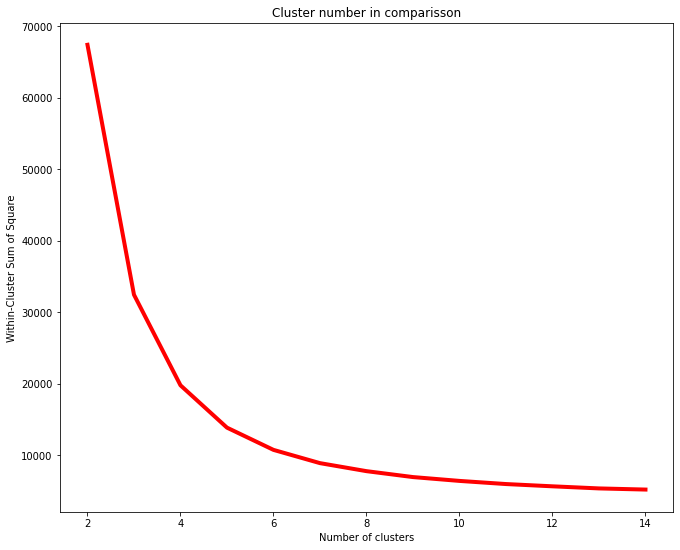

In [ ]:
elbow_method_kmeans(df, model=KMeans, clusters_range=range(2, 15))

Well, this diagram says that we have around [4, 5] clusters in dataset, but as shown above this algorithm can't cath the structure of clusters.

But lets try K-Means modification, Spectral Clustering algorithm, and maybe we can obtain much better results.

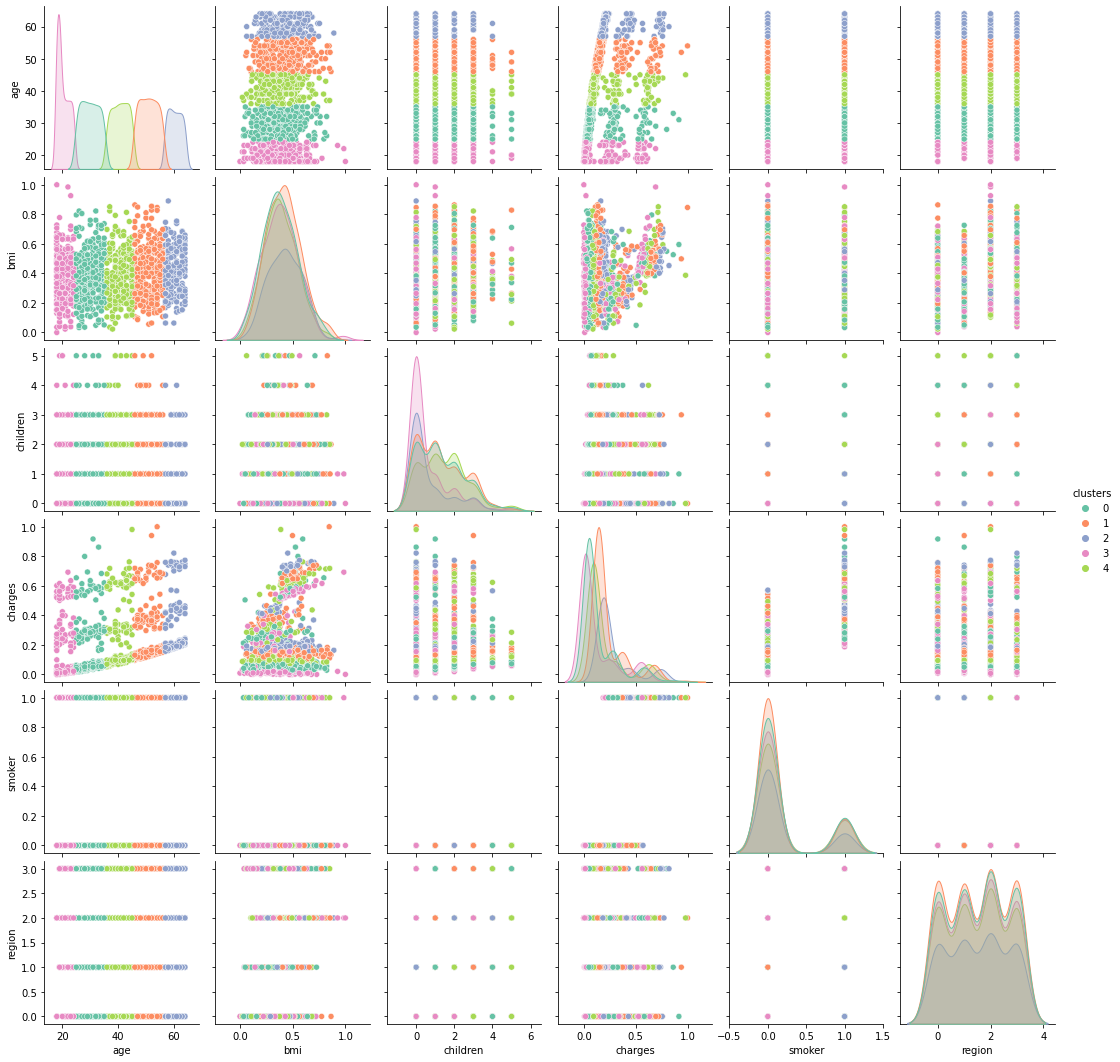

In [ ]:
spetral_rbf = SpectralClustering(n_clusters=5, affinity='rbf', gamma=0.1)
visualise_clustering(df, spetral_rbf)

interestingly, but as we see algorithm clearly try to cluster our customers by age! But as we saw from age to charges diagram there are clearly three groups of people, who buy low, medium and high price insurance.

### Applying scores to evaluate results

Lets evaluate Spectral Clustering Algorithm with Silhoette score

In [ ]:
def silhouette_scores_spectral(df, model, clusters_range, **kwargs):
    """
        This function is used to calculate silhoette scores
        for different number of clusters
    """
    # list to store scores
    scores = []

    # applying clustering
    for i in clusters_range:
        clst = model(n_clusters=i, random_state=42)
        clst.fit(df)
        scores.append(silhouette_score(df, clst.labels_))
    # plotting results
    plt.figure(figsize=(11, 9))
    plt.plot(clusters_range, scores, linewidth=4, color='red')
    plt.title('Cluster number in comparisson')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

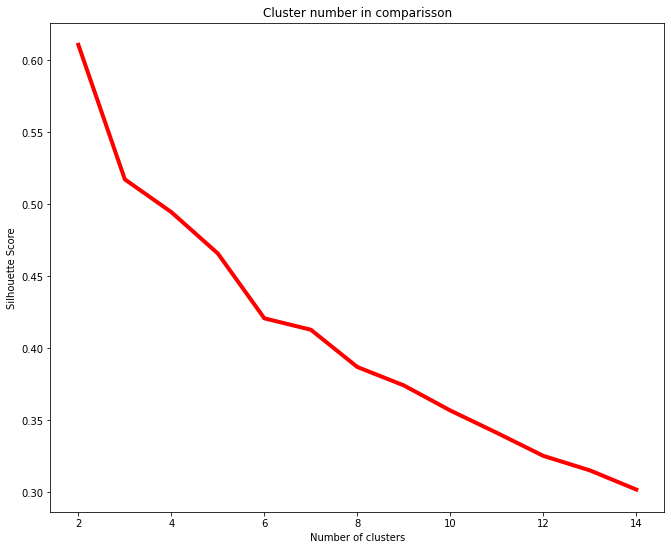

In [ ]:
silhouette_scores_spectral(df, model=SpectralClustering, clusters_range=range(2, 15), gamma=0.1)

The closer score to 1 the better, Silhoette score tells clearly, that we have here 2 clusters, maybe of smoker/non-smoker clients

And to finish our cluster analysis lets use `davies_bouldin_score` to evaluate number of clusters produced by Spectral Clustering algorithm.

In [ ]:
def davies_bouldin_scores_spectral(df, model, clusters_range, **kwargs):
    """
        This function is used to calculate silhoette scores
        for different number of clusters
    """
    # list to store scores
    scores = []

    # applying clustering
    for i in clusters_range:
        clst = model(n_clusters=i, random_state=42)
        clst.fit(df)
        scores.append(davies_bouldin_score(df, clst.labels_))
    # plotting results
    plt.figure(figsize=(11, 9))
    plt.plot(clusters_range, scores, linewidth=4, color='red')
    plt.title('Cluster number in comparisson')
    plt.xlabel('Number of clusters')
    plt.ylabel('Davies-Bouldin Score')
    plt.show()

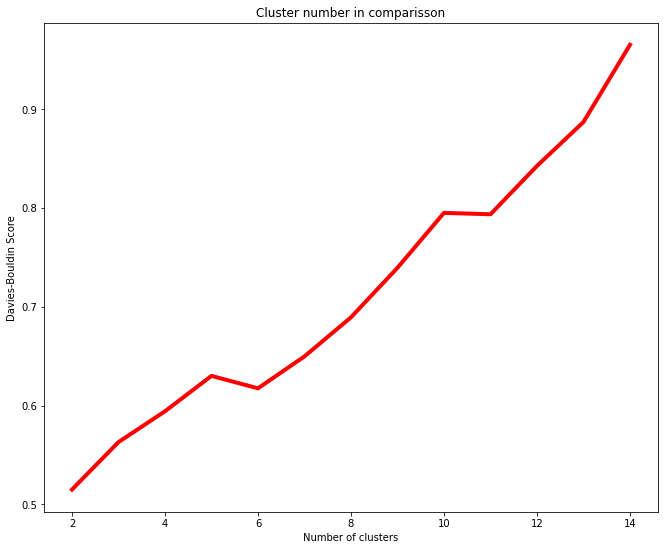

In [ ]:
davies_bouldin_scores_spectral(df, model=SpectralClustering, clusters_range=range(2, 15), gamma=0.1)

And here we see clearly, that the best results are produced by the least amount of clusters. The closer score to zero, the better clustering performed



---



After all performed analysis, we should save transformed dataset and use it in further tasks.

In [ ]:
df.to_csv('prepared_data.csv', index=False)